In [2]:
# import the libraries
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, BatchNormalization, Dropout

import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!7z x /content/drive/MyDrive/Classes.zip


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/                                 1 file, 190278912 bytes (182 MiB)

Extracting archive: /content/drive/MyDrive/Classes.zip
 39% 4096 Open              --
Path = /content/drive/MyDrive/Classes.zip
Type = zip
Physical Size = 190278912

  0%      5% 616 - Classes/ No_DR/5196_left.jpeg                                         10% 1032 - Classes/ No_DR/8753_right.jpeg                                           13% 1378 - Classes/ No_DR/11593_left.jpeg

In [5]:
import pathlib
data_dir = '/content/Classes'
data_dir = pathlib.Path(data_dir)

In [6]:
image_count = len(list(data_dir.glob('*/*.jpeg')))
print(image_count)

10304


In [7]:
batch_size = 32
img_height = 299
img_width = 299

In [8]:
dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    shuffle = True,
    image_size = (img_height, img_width),
    batch_size = batch_size)

Found 10304 files belonging to 2 classes.


In [9]:
class_names = dataset.class_names
print(class_names)

[' No_DR', 'DR']


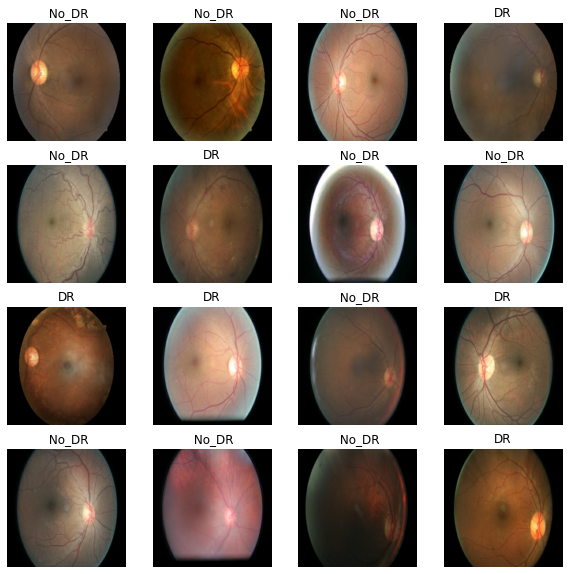

In [10]:
plt.figure(figsize=(10, 10))
for images_batch, labels_batch in dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [11]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10304 files belonging to 2 classes.
Using 7213 files for training.


In [12]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10304 files belonging to 2 classes.
Using 3091 files for validation.


In [13]:
num_classes = len(class_names)

# Transfer Learning

In [14]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model

In [15]:
base_res = model = ResNet50(weights='imagenet', include_top=False)
base_res.summary()

94765736/94765736 [==============================] - 5s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                          

In [16]:
base_res.trainable = False

In [17]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_res(image_batch)
print(feature_batch.shape)

(32, 10, 10, 2048)


In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [19]:
prediction_layer = tf.keras.layers.Dense(8, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 8)


In [20]:
inputs = keras.Input(shape=(img_height, img_width, 3))
x = base_res(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.05)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [22]:
import time
start_cnn = time.time()

In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

path = 'best_model_den.hdf5'
checkpoint = ModelCheckpoint(path, monitor='val_accuracy', verbose = 1, save_best_only = True, mode='max')
es = EarlyStopping(monitor='val_accuracy', patience=10)

callback_list = [checkpoint,es]

In [25]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs, 
  callbacks=callback_list  
)

Epoch 1/50
226/226 [==============================] - ETA: 0s - loss: 0.7088 - accuracy: 0.5787
Epoch 1: val_accuracy improved from -inf to 0.63766, saving model to best_model_den.hdf5
226/226 [==============================] - 69s 290ms/step - loss: 0.7088 - accuracy: 0.5787 - val_loss: 0.6437 - val_accuracy: 0.6377
Epoch 2/50
226/226 [==============================] - ETA: 0s - loss: 0.6391 - accuracy: 0.6366
Epoch 2: val_accuracy improved from 0.63766 to 0.64316, saving model to best_model_den.hdf5
226/226 [==============================] - 63s 277ms/step - loss: 0.6391 - accuracy: 0.6366 - val_loss: 0.6304 - val_accuracy: 0.6432
Epoch 3/50
226/226 [==============================] - ETA: 0s - loss: 0.6256 - accuracy: 0.6473
Epoch 3: val_accuracy did not improve from 0.64316
226/226 [==============================] - 63s 277ms/step - loss: 0.6256 - accuracy: 0.6473 - val_loss: 0.6353 - val_accuracy: 0.6351
Epoch 4/50
226/226 [==============================] - ETA: 0s - loss: 0.6211 -

In [27]:
scores = model.evaluate(val_ds)

97/97 [==============================] - 19s 190ms/step - loss: 0.6182 - accuracy: 0.6577


In [28]:
scores = model.evaluate(train_ds)

226/226 [==============================] - 45s 197ms/step - loss: 0.5278 - accuracy: 0.7359


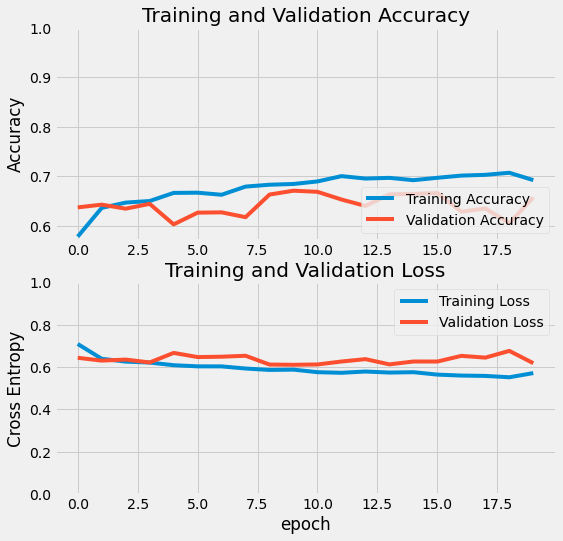

In [29]:
plt.style.use('fivethirtyeight')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [30]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 21ms/step


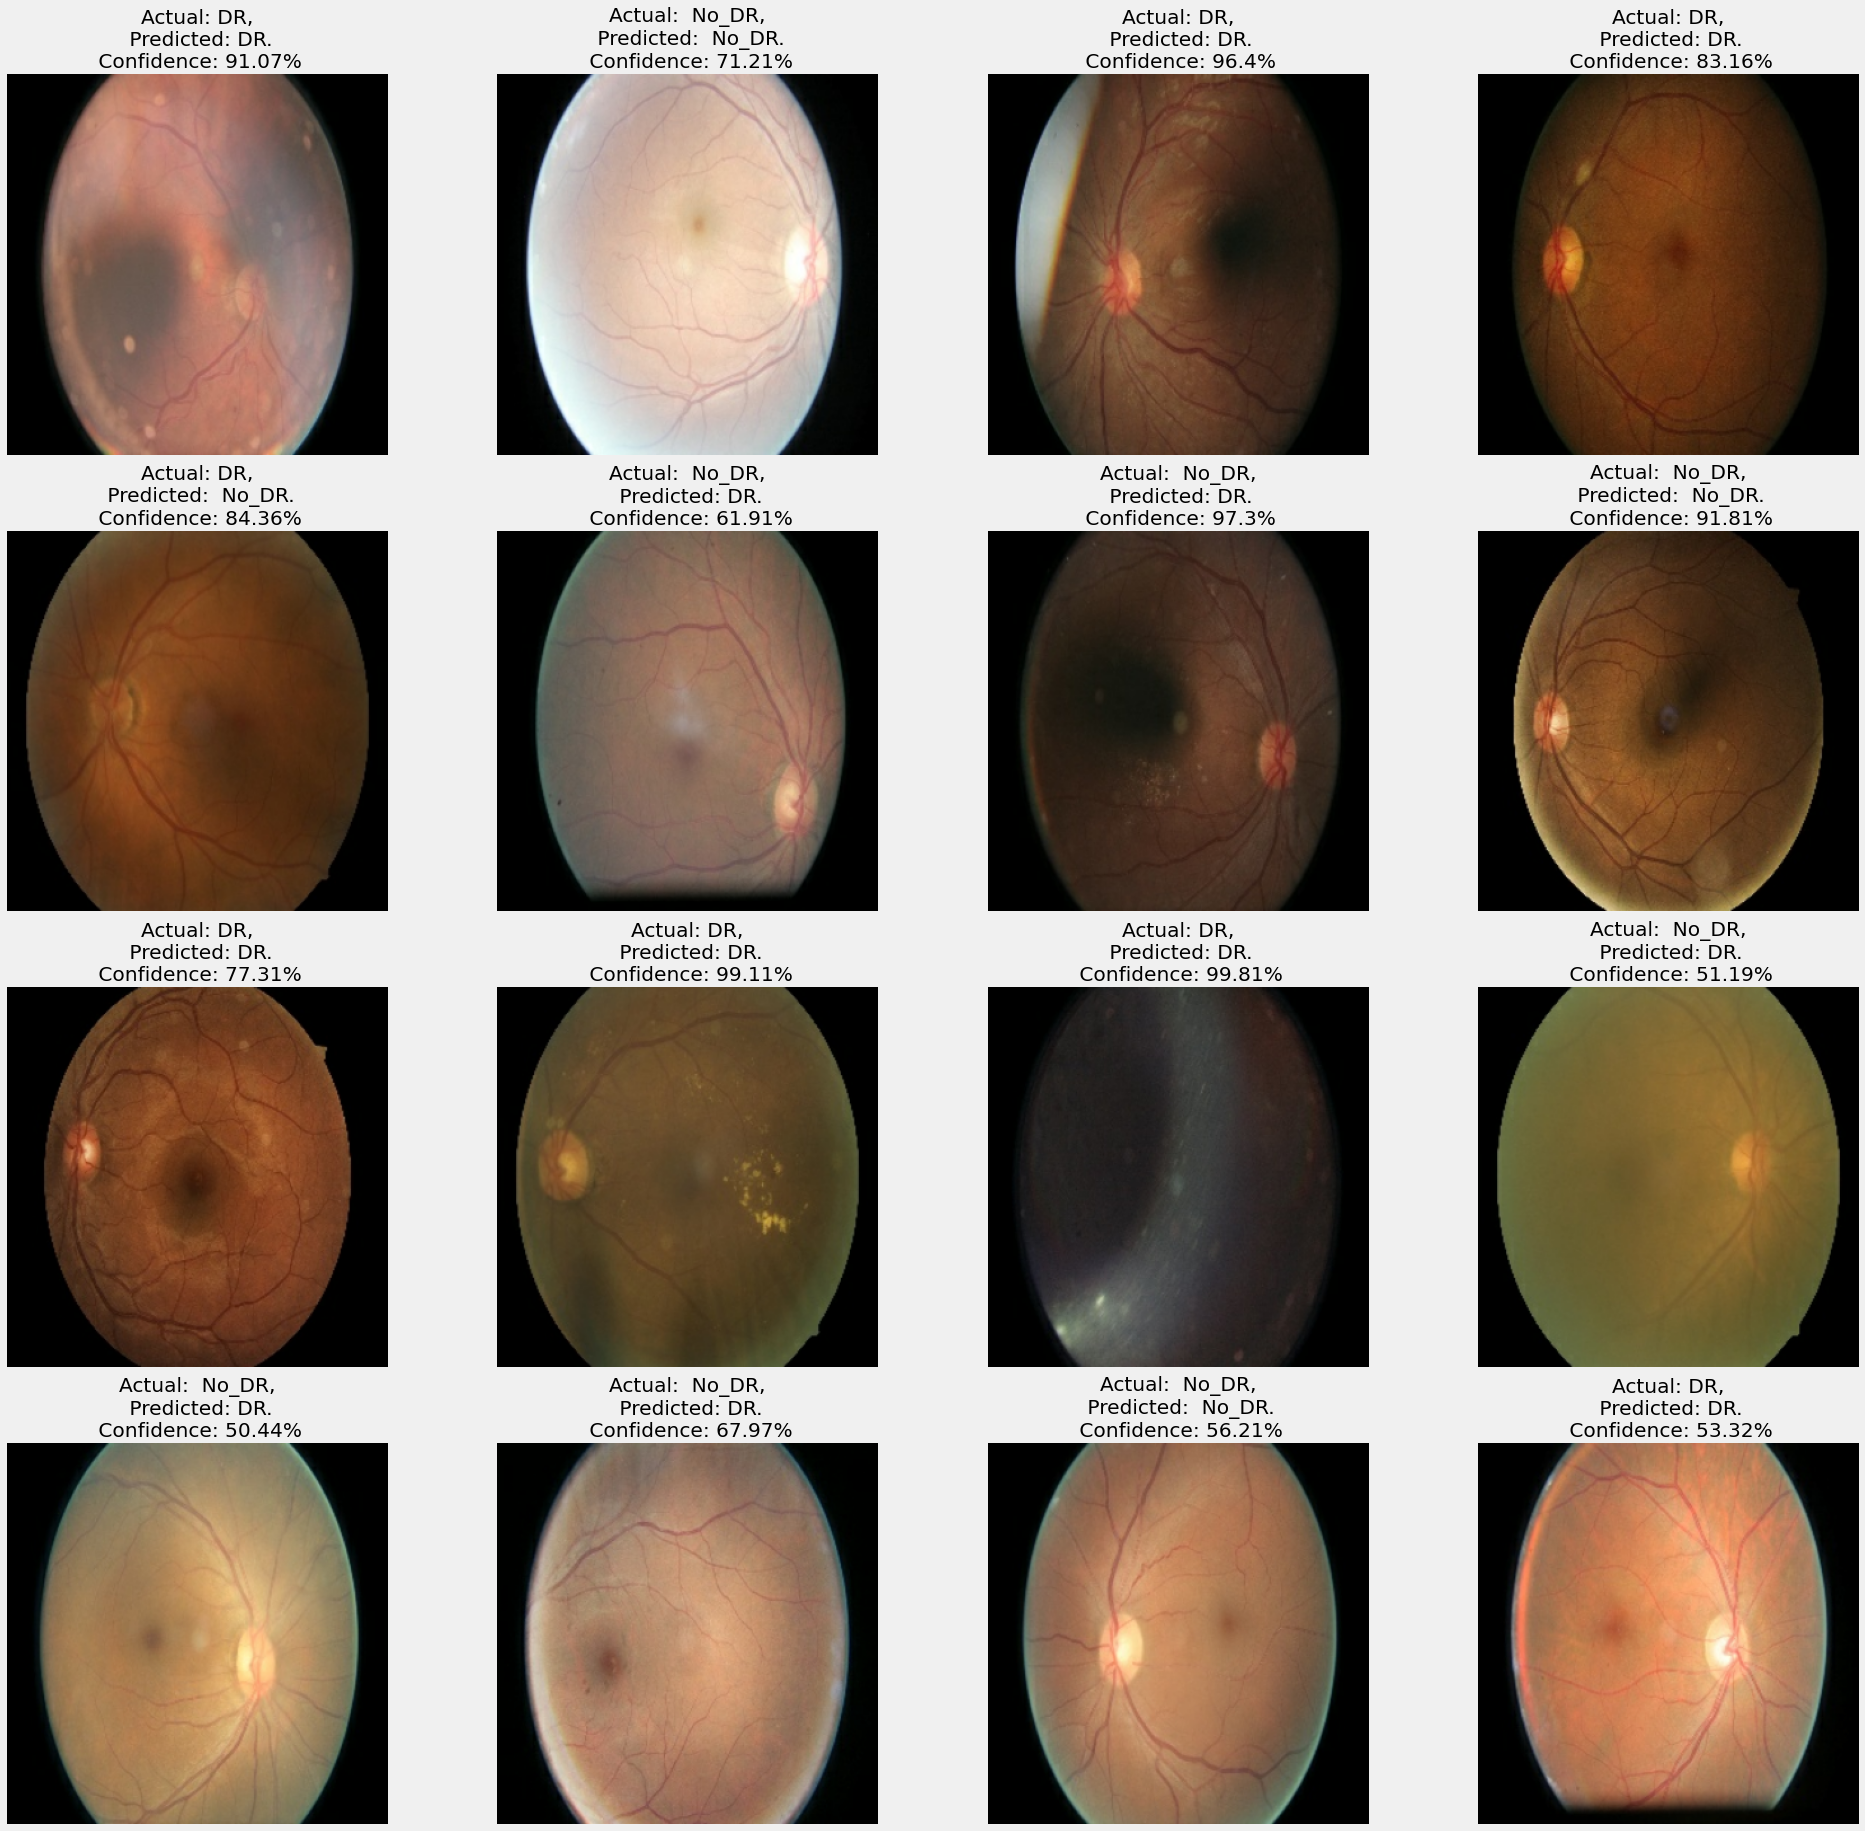

In [31]:
plt.figure(figsize=(30, 30))
for images, labels in val_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [33]:
X = []
y = []
for image,labels in val_ds.take(96):
    for i in image:
        img = i.numpy()
        X.append(img)
    lbl_list = labels.numpy()    
    y.extend(lbl_list)   

In [34]:
x = np.array(X)

In [35]:
y = np.array(y)

In [36]:
x.shape

(3072, 299, 299, 3)

In [37]:
x.shape, y.shape

((3072, 299, 299, 3), (3072,))

In [38]:
model.evaluate(x[:3072],y[:3072])

96/96 [==============================] - 17s 176ms/step - loss: 0.6185 - accuracy: 0.6576


[0.6184633374214172, 0.6575520634651184]

In [40]:
from sklearn.metrics import confusion_matrix , classification_report
import numpy as np
y_pred = model.predict(x[:3072])
y_pred_classes = [np.argmax(element) for element in y_pred]
 
print("Classification Report: \n", classification_report(y[:3072], y_pred_classes))

96/96 [==============================] - 17s 179ms/step
Classification Report: 
               precision    recall  f1-score   support

           0       0.69      0.59      0.64      1560
           1       0.63      0.72      0.68      1512

    accuracy                           0.66      3072
   macro avg       0.66      0.66      0.66      3072
weighted avg       0.66      0.66      0.66      3072

